# OLAP

## Grupo 3

### Integrantes

* Cuzziol Boccioni Facundo Ramiro
* Nadal Alejandro Fabian
* Schuster Exequiel Andres
* Soto Juan Cruz


### Librerias utilizadas

* Pandas: esencial para almacenar y manipular datos
* Atoti: una libreria para crear y realizar operaciones sobre cubos OLAP

In [1]:
!pip3 install graphviz

In [2]:
import atoti as tt
import pandas as pd



Una **sesion** almacena un cubo o conjunto de cubos, y toda la data de los mismos

In [3]:
config = tt.config.create_config(port=62765, metadata_db="./metadata.db")
session = tt.create_session(config=config)

In [4]:
session.load_all_data()

Se cargan los csv, cada uno, a un Pandas DataFrame

In [5]:
operations_df = pd.read_csv('./Data/Operations.csv')
type_df = pd.read_csv('./Data/Type.csv')
date_df = pd.read_csv('./Data/Date.csv')
client_df = pd.read_csv('./Data/Client.csv')
account_df = pd.read_csv('./Data/Account.csv')
district_df = pd.read_csv('./Data/District.csv')
orders_df = pd.read_csv('./Data/Orders.csv')
account_receiver_df = account_df
date_d_df = date_df.copy()
client_district_df = district_df.copy()

In [6]:
orders_df.columns

Index(['order_id', 'type_id', 'account_key', 'receiver', 'client_id',
       'district_id', 'client_district_id', 'amount', 'amount_avg',
       'quantity'],
      dtype='object')

Atoti requiere que cada dimension posea atributos con noombres distintos, por lo que en esta zona realizamos algunas transformaciones a los dataframe para evitar inconvenientes

In [7]:
account_receiver_df = account_receiver_df.drop(columns=['district_id','extraction_freq','start_date','end_date','created_date'])

In [8]:
account_receiver_df.columns = ['r_account_key','r_account_id','r_bank']

In [9]:
client_district_df.columns = ['cd_district_id', 'cd_unemployment_rate_95', 'cd_unemployment_rate_96',
       'cd_entrepreneur_num1000', 'cd_encd_date', 'cd_crimes_num_95',
       'cd_crimes_num_96', 'cd_start_date', 'cd_district_name',
       'cd_inhabitants_num', 'cd_municipality_num499',
       'cd_municipality_num499_1999', 'cd_municipality_num2000_9999',
       'cd_municipality_num10000', 'cd_city_num', 'cd_region',
       'cd_urban_inhabitants_proportion', 'cd_medium_salary']

In [10]:
client_df.columns = ['c_client_id','c_district_id','c_gender','c_age','c_age_levels','c_card_num','c_card_type','c_card_emission_date','c_account_owner']

In [11]:
orders_df.columns = ['o_order_id','o_type_id','o_account_key','o_receiver','o_client_id','o_district_id','o_client_district_id','o_amount','o_amount_avg','o_quantity']

In [12]:
account_df = account_df.drop(columns=['bank'])

In [13]:
district_df.columns = ['d_district_id', 'd_unemployment_rate_95', 'd_unemployment_rate_96',
       'd_entrepreneur_num1000', 'd_end_date', 'd_crimes_num_95', 'd_crimes_num_96',
       'd_start_date', 'd_district_name', 'd_inhabitants_num', 'd_municipality_num499',
       'd_municipality_num499_1999', 'd_municipality_num2000_9999',
       'd_municipality_num10000', 'd_city_num', 'd_region',
       'd_urban_inhabitants_proportion', 'd_medium_salary']


In [14]:
date_d_df.columns = ['date_id_d','day_val_d','month_val_d','year_val_d','semester_val_d']

Se crean las dimensiones, con una funcion que lee directamente desde los dataframe

In [15]:
operations = session.read_pandas(operations_df,keys=['operation_id'],store_name='operations')
types = session.read_pandas(type_df,keys=['type_id'],store_name='types')
date = session.read_pandas(date_df, keys=['date_id'], store_name='date')
date_d = session.read_pandas(date_d_df, keys=['date_id_d'], store_name='date_d')
account = session.read_pandas(account_df, keys=['account_key'], store_name='account')
account_receiver = session.read_pandas(account_receiver_df, keys=['r_account_key'], store_name='account_receiver')
clients = session.read_pandas(client_df,keys=['c_client_id'],store_name='clients')
districts = session.read_pandas(district_df, keys=['d_district_id'], store_name='districts')
orders = session.read_pandas(orders_df, keys=['o_order_id'], store_name='orders')
client_district = session.read_pandas(client_district_df,keys=['cd_district_id'], store_name='clients_districts')

In [16]:
orders.join(types,mapping={"o_type_id":"type_id"})

In [17]:
orders.join(districts,mapping={"o_district_id":"d_district_id"})
orders.join(clients,mapping={'o_client_id':'c_client_id'})
orders.join(account, mapping={'o_account_key' : 'account_key'})
orders.join(account_receiver, mapping={'o_receiver' : 'r_account_key'})
orders.join(client_district,mapping={"o_client_district_id":"cd_district_id"})

In [18]:
operations.join(types,mapping={"type_id":"type_id"})
operations.join(date,mapping={"date_id" : "date_id"})
operations.join(date_d,mapping={"date_id" : "date_id_d"})
operations.join(account, mapping={"account_key" : "account_key"})
operations.join(account_receiver, mapping={"receiver" : "r_account_key"})
operations.join(clients,mapping={'client_id':'c_client_id'})
operations.join(districts, mapping={'district_id': 'd_district_id'})
operations.join(client_district,mapping={'client_district_id': 'cd_district_id'})

In [19]:
cube = session.create_cube(operations,mode='manual')

In [20]:
cube2 = session.create_cube(orders,mode='manual')

In [21]:
h, l, m = cube.hierarchies, cube.levels, cube.measures

In [22]:
h2, l2, m2 = cube2.hierarchies, cube2.levels, cube2.measures

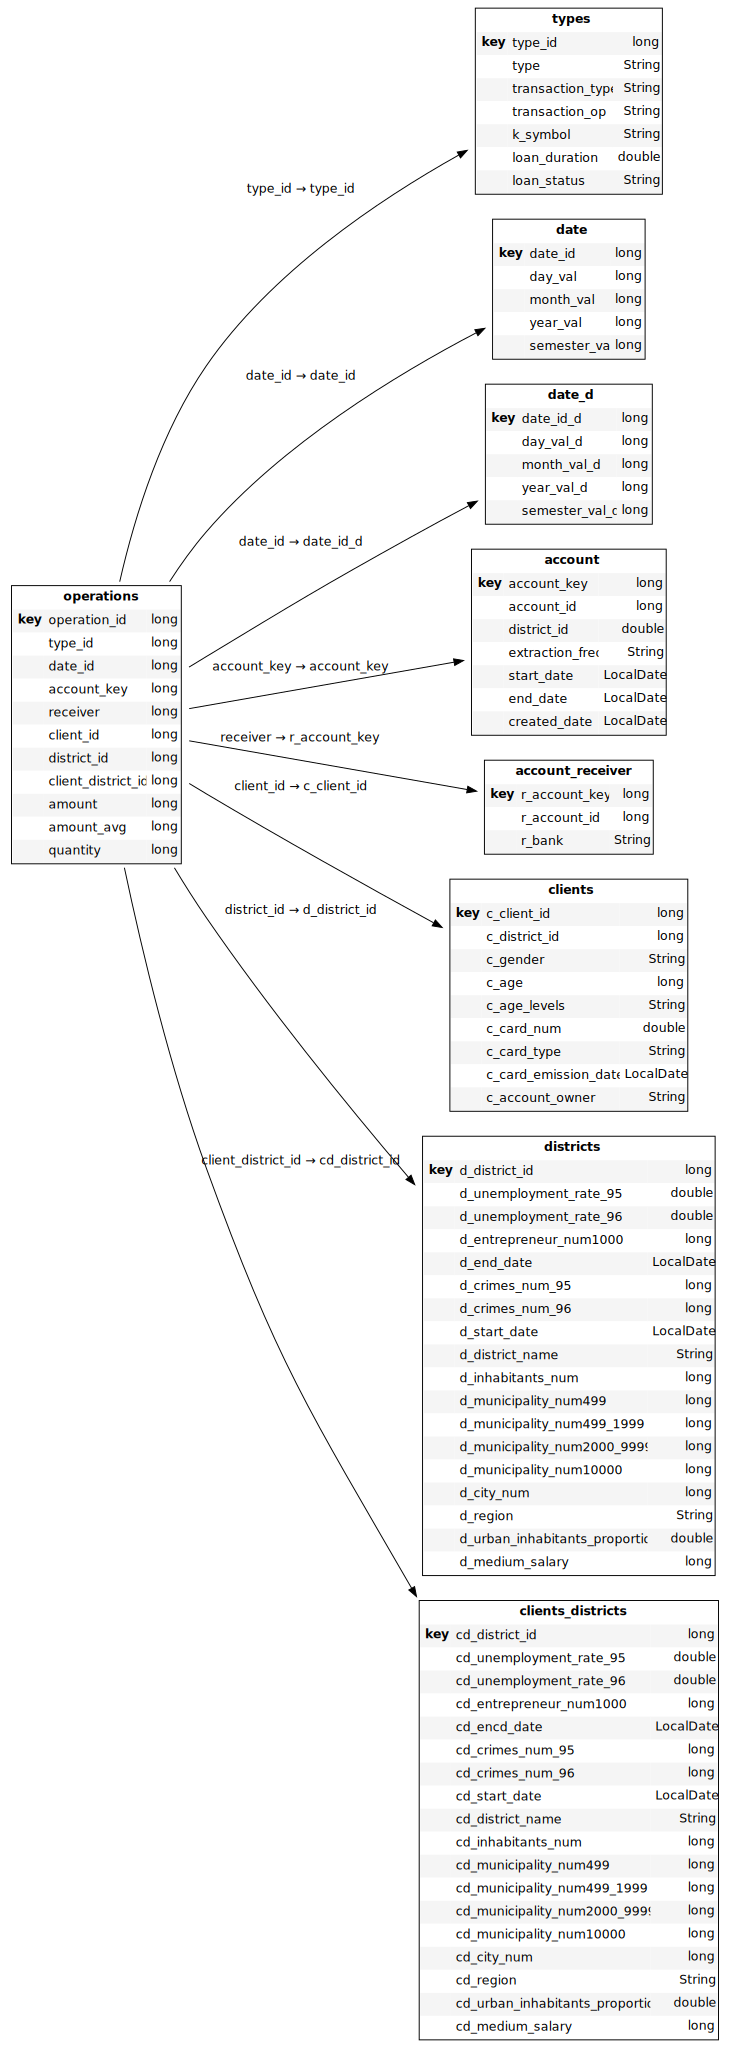

In [23]:
cube.schema

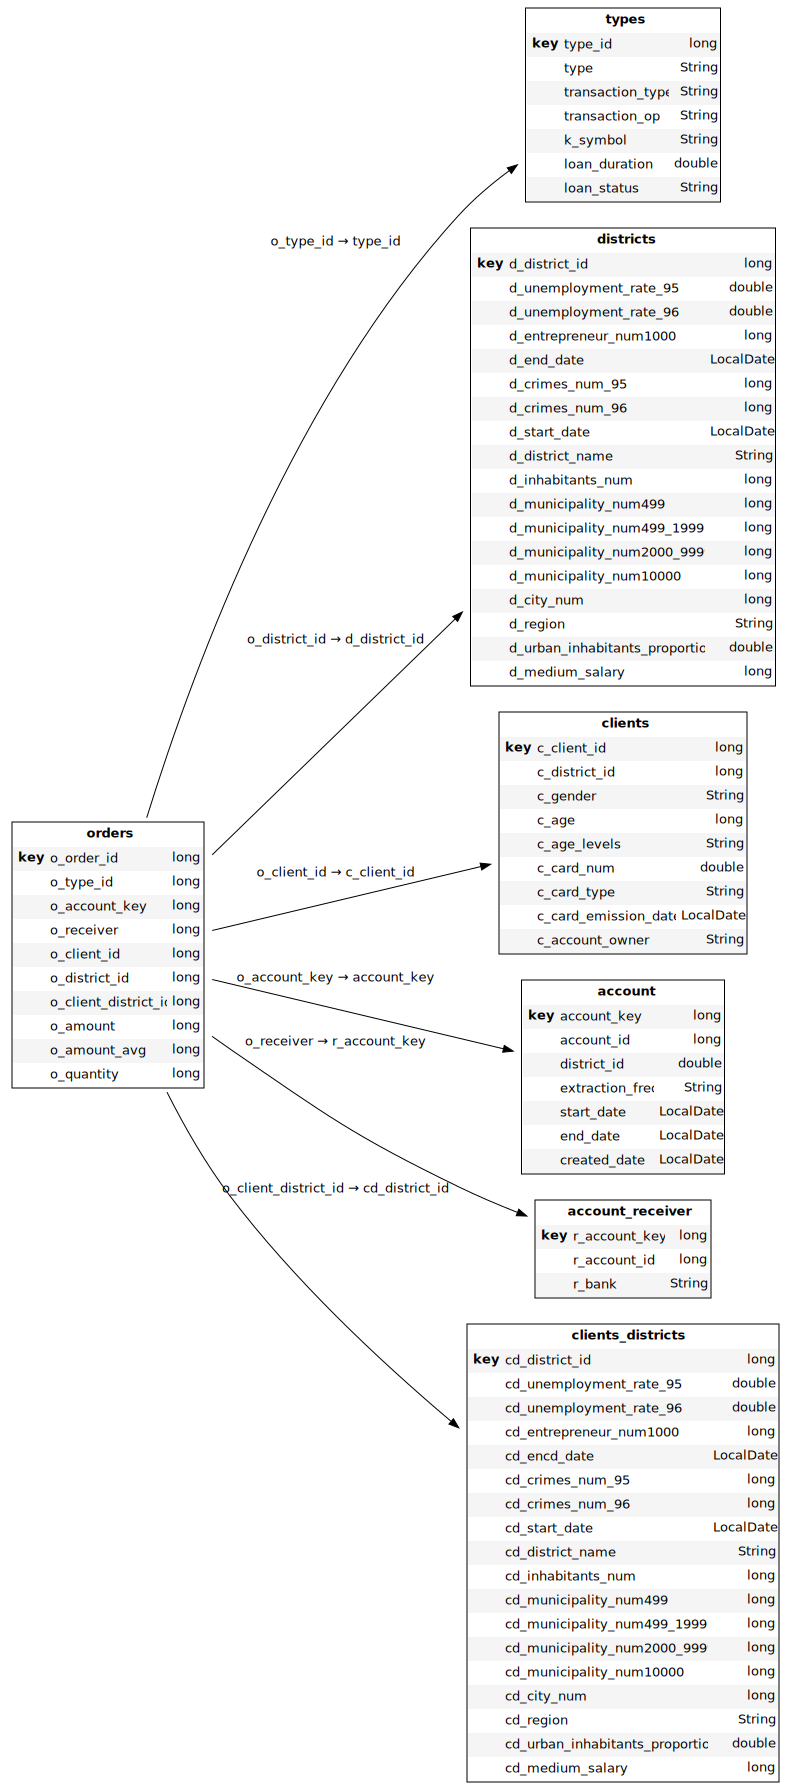

In [24]:
cube2.schema

In [25]:
h['type'] =[
    types['type']
]
h['transaction_type'] = [
    types['transaction_type']
]
h['transaction_op']=[
    types['transaction_op']
]
h['day'] = [
    date['day_val']
]
h['month'] = [
    date['month_val']
]
h['semester'] = [
    date['semester_val']
]
h['year'] = [
    date['year_val']
]
h['account'] = [
    account['account_id']
]
h['extraction_freq'] = [
    account['extraction_freq']
]
h['receiver'] = [
    account_receiver['r_account_key']
]
h['receiver_bank'] = [
    account_receiver['r_bank']
]
h['k_symbol'] = [
    types['k_symbol']
]
h['client_id'] = [
    clients['c_client_id']
]
h['district_id'] = [
    clients['c_district_id']
]
h['gender']=[
    clients['c_gender']
]
h['age']=[
    clients['c_age']
]
h['age_levels']=[
    clients['c_age_levels']
]
h['card_num']=[
    clients['c_card_num']
]
h['card_type']=[
    clients['c_card_type']
]
h['card_emission_date']=[
    clients['c_card_emission_date']
]
h['account_owner']=[
    clients['c_account_owner']
]
h['d_district_id'] = [
    districts['d_district_id']
]
h['d_unemployment_rate_95'] = [districts['d_unemployment_rate_95']]
h['d_unemployment_rate_96'] = [districts['d_unemployment_rate_96']]
h['d_entrepreneur_num1000'] = [districts['d_entrepreneur_num1000']]
h['d_end_date'] = [districts['d_end_date']]
h['d_crimes_num_95'] = [districts['d_crimes_num_95']]
h['d_crimes_num_96'] = [districts['d_crimes_num_96']]
h['d_start_date'] = [districts['d_start_date']]
h['d_district_name'] = [districts['d_district_name']]
h['d_inhabitants_num'] = [districts['d_inhabitants_num']]
h['d_municipality_num499'] = [districts['d_municipality_num499']]
h['d_municipality_num499_1999'] = [districts['d_municipality_num499_1999']]
h['d_municipality_num2000_9999'] = [districts['d_municipality_num2000_9999']]
h['d_municipality_num10000'] = [districts['d_municipality_num10000']]
h['d_city_num'] = [districts['d_city_num']]
h['d_region'] = [districts['d_region']]
h['d_urban_inhabitants_proportion'] = [districts['d_urban_inhabitants_proportion']]
h['d_medium_salary'] = [districts['d_medium_salary']]

h['day_d'] = [
    date_d['day_val_d']
]
h['month_d'] = [
    date_d['month_val_d']
]
h['semester_d'] = [
    date_d['semester_val_d']
]
h['year_d'] = [
    date_d['year_val_d']
]

h['client_district_id'] = [
    client_district['cd_district_id']
]
h['client_region'] = [
    client_district['cd_region']
]

In [26]:
h2['type'] =[
    types['type']
]
h2['transaction_type'] = [
    types['transaction_type']
]
h2['transaction_op']=[
    types['transaction_op']
]
h2['k_symbol'] = [
    types['k_symbol']
]
h['d_district_id'] = [
    districts['d_district_id']
]
h2['d_unemployment_rate_95'] = [districts['d_unemployment_rate_95']]
h2['d_unemployment_rate_96'] = [districts['d_unemployment_rate_96']]
h2['d_entrepreneur_num1000'] = [districts['d_entrepreneur_num1000']]
h2['d_end_date'] = [districts['d_end_date']]
h2['d_crimes_num_95'] = [districts['d_crimes_num_95']]
h2['d_crimes_num_96'] = [districts['d_crimes_num_96']]
h2['d_start_date'] = [districts['d_start_date']]
h2['d_district_name'] = [districts['d_district_name']]
h2['d_inhabitants_num'] = [districts['d_inhabitants_num']]
h2['d_municipality_num499'] = [districts['d_municipality_num499']]
h2['d_municipality_num499_1999'] = [districts['d_municipality_num499_1999']]
h2['d_municipality_num2000_9999'] = [districts['d_municipality_num2000_9999']]
h2['d_municipality_num10000'] = [districts['d_municipality_num10000']]
h2['d_city_num'] = [districts['d_city_num']]
h2['d_region'] = [districts['d_region']]
h2['d_urban_inhabitants_proportion'] = [districts['d_urban_inhabitants_proportion']]
h2['d_medium_salary'] = [districts['d_medium_salary']]

h2['client_id'] = [
    clients['c_client_id']
]
h2['district_id'] = [
    clients['c_district_id']
]
h2['gender']=[
    clients['c_gender']
]
h2['age']=[
    clients['c_age']
]
h2['age_levels']=[
    clients['c_age_levels']
]
h2['card_num']=[
    clients['c_card_num']
]
h2['card_type']=[
    clients['c_card_type']
]
h2['card_emission_date']=[
    clients['c_card_emission_date']
]
h2['account_owner']=[
    clients['c_account_owner']
]
h2['account'] = [
    account['account_id']
]
h2['extraction_freq'] = [
    account['extraction_freq']
]
h2['receiver'] = [
    account_receiver['r_account_key']
]
h2['receiver_bank'] = [
    account_receiver['r_bank']
]

h2['client_district_id'] = [
    client_district['cd_district_id']
]
h2['client_region'] = [
    client_district['cd_region']
]

In [27]:
#h

In [28]:
#h2

In [29]:
h['date'] = [l['year_val'],l['semester_val'],l['month_val'],l['day_val']]
del h['day']
del h['month']
del h['semester']
del h['year']

In [30]:
#l

In [31]:
#l2

In [32]:
m["amount_avg"] = tt.agg.mean(operations["amount_avg"])

In [33]:
m['quantity'] = tt.agg.sum(operations['quantity'])

In [34]:
m['amount'] = tt.agg.sum(operations['amount'])

In [35]:
m['cards'] = tt.filter(tt.agg.count_distinct(operations['client_id']),l['c_card_num'] != 0.0)

In [36]:
m2["amount_avg"] = tt.agg.mean(orders["o_amount_avg"])

In [37]:
m2['quantity'] = tt.agg.sum(orders['o_quantity'])

In [38]:
m2['amount'] = tt.agg.sum(orders['o_amount'])

In [39]:
cube.query(m['amount_avg'],include_totals=True,levels=[l['type'],l['transaction_type'],l['transaction_op']])

amount_avg
type        transaction_type   transaction_op                          
Total                                                          6,033.30
Prestamo                                                     151,410.18
            N/A                                              151,410.18
                               N/A                           151,410.18
Transaccion                                                    5,937.86
            Credito                                            8,053.06
                               Coleccion de otro banco        11,981.11
                               Credito en efectivo            15,388.10
                               N/A                               150.32
            Debito                                             4,421.05
                               Remesa a otro banco             3,229.44
                               Retiro de tarjeta de credito    2,270.96
                               Retiro en efectivo              5,068.27
            Retiro en Efectivo                                12,519.06
                               Retiro en efectivo             12,519.06

In [40]:
cube2.query(m2['amount_avg'],include_totals=True,levels=[l2['type'],l2['transaction_type'],l2['transaction_op']])

amount_avg
type  transaction_type transaction_op           
Total                                   3,280.64
Orden                                   3,280.64
      N/A                               3,280.64
                       N/A              3,280.64

In [41]:
cube.query(m['quantity'],include_totals=True,levels=[l['type'],l['transaction_type'],l['transaction_op']])

quantity
type        transaction_type   transaction_op                         
Total                                                        1,057,002
Prestamo                                                           682
            N/A                                                    682
                               N/A                                 682
Transaccion                                                  1,056,320
            Credito                                            405,083
                               Coleccion de otro banco          65,226
                               Credito en efectivo             156,743
                               N/A                             183,114
            Debito                                             634,571
                               Remesa a otro banco             208,283
                               Retiro de tarjeta de credito      8,036
                               Retiro en efectivo              418,252
            Retiro en Efectivo                                  16,666
                               Retiro en efectivo               16,666

In [42]:
cube2.query(m2['quantity'],include_totals=True,levels=[l2['type'],l2['transaction_type'],l2['transaction_op']])

quantity
type  transaction_type transaction_op         
Total                                    6,471
Orden                                    6,471
      N/A                                6,471
                       N/A               6,471

In [43]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension installed and enabled to start editing this widget.

In [44]:
session.url

'http://localhost:62765'

In [45]:
session

In [46]:
session.cubes.values()

dict_values([Cube(_name='operations', _hierarchies=Hierarchies(), _measures=Measures()), Cube(_name='orders', _hierarchies=Hierarchies(), _measures=Measures())])